In [1]:
import torch
%env CUDA_VISIBLE_DEVICES=0
torch.cuda.is_available()

env: CUDA_VISIBLE_DEVICES=0


True

In [2]:
import scvi
import scanpy as sc
import numpy as np
import pandas as pd
import hotspot
import pickle
import seaborn as sns
import gcsfs
from sklearn.metrics import r2_score 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


/home/boiarskr/GitLab/cancer-sc-embed/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/boiarskr/GitLab/cancer-sc-embed/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global variables

In [3]:
image_savedir = "outputs/pipeline_runs/sys/figures/"

In [4]:
#save scores for NMF scores, cancerMP score
all_NMFscores = {}
all_cancerMPscores = {}

# Read in adata, define HVGs, calculate gene signature scores

In [5]:
# if you've already run this script, read in anndata object with the latents already saved 
# skip rest of this section
file = open('outputs/pipeline_runs/sys/sysadata_updated_latents.pkl', 'rb')
sys_adata = pickle.load(file)
file.close()

In [ ]:
counts = pd.read_table("data/infercnv_input_files/sys/counts.txt", index_col=0)

In [ ]:
cell_annots = pd.read_csv("gs://rebecca-summer23/sys_jerby_data/GSM3770931_SyS.tumors_cell.annotations.csv")

In [ ]:
# limit counts to the cells that are in cell_annots
assert(np.all(cell_annots.title.isin(counts.columns)))

counts = counts.loc[:,cell_annots.title]

In [ ]:
sys_adata = sc.AnnData(counts.T, obs=cell_annots.drop(columns=["Sample name","processed data file","raw file","molecule","source name","organism"]).set_index("title").rename_axis(None, axis=0))

In [ ]:
sys_adata.obs.rename(columns={"characteristics: sample":"sample","characteristics: cell.type":"celltype", "characteristics: tag":"tag"}, inplace=True)

In [ ]:
sc.pp.filter_cells(sys_adata, min_genes=200)
sc.pp.filter_genes(sys_adata, min_cells=3)

In [ ]:
sys_adata.layers['counts'] = sys_adata.X.copy()

In [ ]:
sc.pp.normalize_total(sys_adata, target_sum=1e4)
sc.pp.log1p(sys_adata)
sc.pp.highly_variable_genes(sys_adata, flavor="seurat_v3", layer="counts", n_top_genes=5000)

In [ ]:
sys_adata.raw=sys_adata.copy()

In [ ]:
sc.pp.scale(sys_adata, max_value=10)

In [ ]:
sc.tl.pca(sys_adata, svd_solver='arpack')

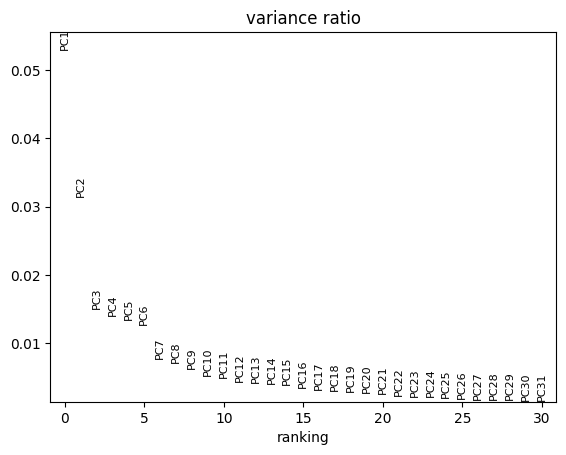

In [45]:
sc.pl.pca_variance_ratio(sys_adata)#, log=True)

In [51]:
sc.pp.neighbors(sys_adata, n_neighbors=10, n_pcs=20)

In [52]:
sc.tl.umap(sys_adata)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


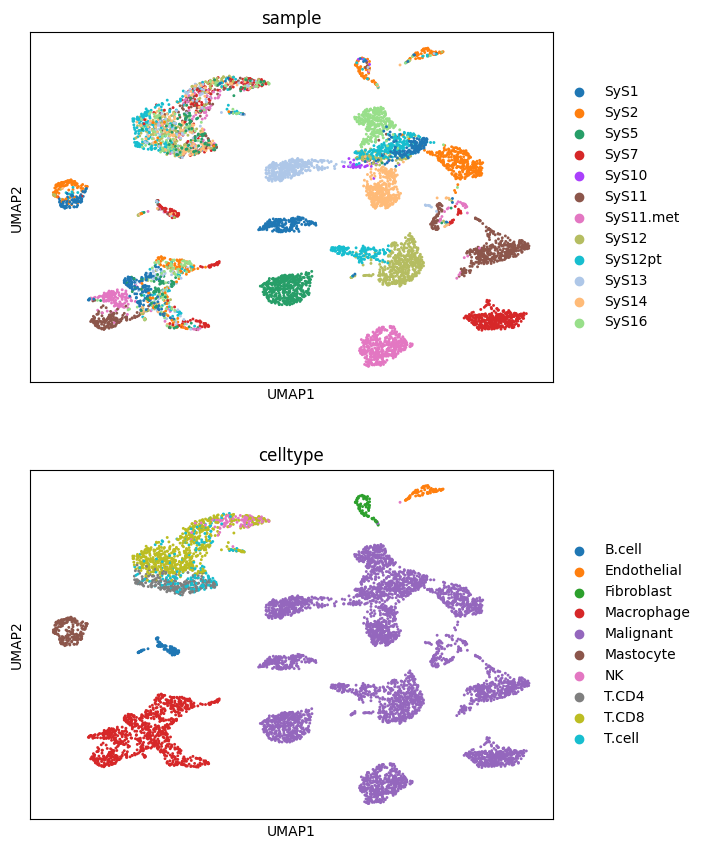

In [54]:
sc.pl.umap(sys_adata, color=['sample','celltype'], ncols=1)

### calculate gene signature scores

In [6]:
cancer_MPs = pd.read_csv("data/hallmarks_supptable2_MPs-CancerMPs.csv")
all_cancerMPscores['signatures'] = [MP.split(" ")[0] for MP in cancer_MPs.columns]

In [17]:
[sc.tl.score_genes(sys_adata, cancer_MPs.loc[:,MP], score_name=MP.split(" ")[0]) for MP in cancer_MPs.columns];

In [19]:
sys_adata_hvg = sys_adata[:, sys_adata.var.highly_variable].copy()
sys_adata_hvg.shape

(6951, 5000)

# Run vanilla scVI over multiple seeds

In [ ]:
for SEED in [2,3,4,5]:
    #settings for this run
    scvi.settings.seed = SEED
    run_name = "scvi_seed{}".format(SEED)

    #run scvi
    scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="counts")
    vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')
    vae.train()

    #save trained model to disk
    file = open('outputs/pipeline_runs/sys/{}.pkl'.format(run_name), 'wb')
    pickle.dump(vae, file)
    file.close()

    #get latents and create UMAP
    sys_adata.obsm[run_name] = vae.get_latent_representation()
    sc.pp.neighbors(sys_adata, use_rep=run_name)
    sc.tl.umap(sys_adata)
    sc.pl.umap(sys_adata, color=["sample","celltype"], show=False)
    plt.savefig(image_savedir+"umap_{}_clinicalcovars.png".format(run_name), bbox_inches="tight")
    
    #save UMAP figures of signatures
    for sig in [m.split(" ")[0] for m in cancer_MPs.columns]:
        sc.pl.umap(sys_adata, color=sig, show=False)
        plt.savefig(image_savedir+"umap_cancer_MPs/umap_{}_{}.png".format(run_name, sig), bbox_inches="tight")

# Run scVI with patient correction over multiple seeds

In [ ]:
for SEED in [1,2,3,4,5]:
    #settings for this run
    scvi.settings.seed = SEED
    run_name = "scvi_batchperson_seed{}".format(SEED)

    #run scvi
    scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="counts", batch_key="sample")
    vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')
    vae.train()

    #save trained model to disk
    file = open('outputs/pipeline_runs/sys/{}.pkl'.format(run_name), 'wb')
    pickle.dump(vae, file)
    file.close()

    #get latents and create UMAP
    sys_adata.obsm[run_name] = vae.get_latent_representation()
    sc.pp.neighbors(sys_adata, use_rep=run_name)
    sc.tl.umap(sys_adata)
    sc.pl.umap(sys_adata, color=["sample","celltype"], show=False)
    plt.savefig(image_savedir+"umap_{}_clinicalcovars.png".format(run_name), bbox_inches="tight")
    
    #save UMAP figures of signatures
    for sig in [m.split(" ")[0] for m in cancer_MPs.columns]:
        sc.pl.umap(sys_adata, color=sig, show=False)
        plt.savefig(image_savedir+"umap_cancer_MPs/umap_{}_{}.png".format(run_name, sig), bbox_inches="tight")

# Run scVI with CNV continuous correction across multiple seeds

### load inferCNV results, which have been preprocessed in a separate script

In [22]:
!gsutil cp gs://rebecca-summer23/outputs/cnv_array_sys.pkl /tmp/cnv_array_sys.pkl
file = open('/tmp/cnv_array_sys.pkl', 'rb')
cnv_array = pickle.load(file)
file.close()

Copying gs://rebecca-summer23/outputs/cnv_array_sys.pkl...
\ [1 files][  1.1 GiB/  1.1 GiB]   78.6 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


### run PCA on CNVs, add representation to adata

In [23]:
cnv_df = pd.DataFrame(cnv_array, index=sys_adata.obs.index, columns = sys_adata.var.index)

In [24]:
cnv_dense = cnv_df.loc[:,~np.all(cnv_df==1, axis=0)]

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
cnv_pc = pca.fit_transform(cnv_dense)

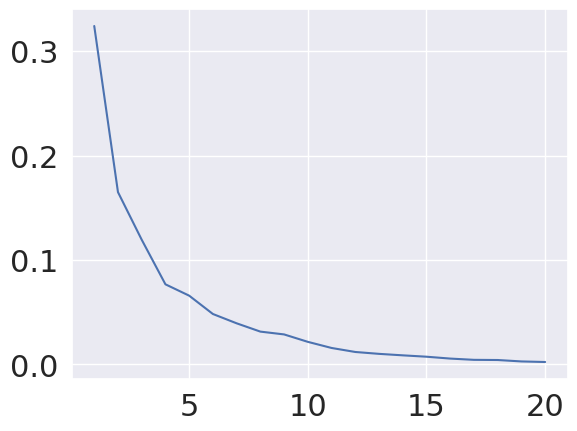

In [26]:
#frac explained variance
import matplotlib.pyplot as plt
plt.plot(np.arange(20)+1, pca.explained_variance_ratio_)

In [27]:
cnv_pc_df = pd.DataFrame(cnv_pc, index=sys_adata.obs.index, columns = ["cnv_PC"+str(i) for i in np.arange(20)+1])

In [35]:
sys_adata.obs = sys_adata.obs.merge(cnv_pc_df, right_index=True, left_index=True)

In [36]:
sys_adata_hvg = sys_adata[:,sys_adata.var.highly_variable].copy()

In [ ]:
n_pcs = 7
for SEED in [1,2,3,4,5]:
    #settings for this run
    scvi.settings.seed = SEED
    run_name = "scvi_CNVcont_PCs{}_seed{}".format(n_pcs, SEED)

    #run scvi
    scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="counts", continuous_covariate_keys=["cnv_PC"+str(i) for i in np.arange(n_pcs)+1])
    vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')
    vae.train()

    #save trained model to disk
    file = open('outputs/pipeline_runs/sys/{}.pkl'.format(run_name), 'wb')
    pickle.dump(vae, file)
    file.close()

    #get latents and create UMAP
    sys_adata.obsm[run_name] = vae.get_latent_representation()
    sc.pp.neighbors(sys_adata, use_rep=run_name)
    sc.tl.umap(sys_adata)
    sc.pl.umap(sys_adata, color=["sample","celltype"], show=False)
    plt.savefig(image_savedir+"umap_{}_clinicalcovars.png".format(run_name), bbox_inches="tight")
    
    #save UMAP figures of signatures
    for sig in [m.split(" ")[0] for m in cancer_MPs.columns]:
        sc.pl.umap(sys_adata, color=sig, show=False)
        plt.savefig(image_savedir+"umap_cancer_MPs/umap_{}_{}.png".format(run_name, sig), bbox_inches="tight")

# Save anndata with all these different latents to disk

In [56]:
file = open('outputs/pipeline_runs/sys/sysadata_updated_latents.pkl', 'wb')
pickle.dump(sys_adata, file)
file.close()

In [55]:
sys_adata

AnnData object with n_obs × n_vars = 6951 × 21759
    obs: 'sample', 'celltype', 'tag', 'description', 'n_genes', 'MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6', 'MP7', 'MP8', 'MP9', 'MP10', 'MP11', 'MP12', 'MP13', 'MP14', 'MP15', 'MP16', 'MP17', 'MP18', 'MP19', 'MP20', 'MP21', 'MP22', 'MP23', 'MP24', 'MP25', 'MP26', 'MP27', 'MP28', 'MP29', 'MP30', 'MP31', 'MP32', 'MP33', 'MP34', 'MP35', 'MP36', 'MP37', 'MP38', 'MP39', 'MP40', 'MP41', 'cnv_PC1', 'cnv_PC2', 'cnv_PC3', 'cnv_PC4', 'cnv_PC5', 'cnv_PC6', 'cnv_PC7', 'cnv_PC8', 'cnv_PC9', 'cnv_PC10', 'cnv_PC11', 'cnv_PC12', 'cnv_PC13', 'cnv_PC14', 'cnv_PC15', 'cnv_PC16', 'cnv_PC17', 'cnv_PC18', 'cnv_PC19', 'cnv_PC20'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'sample_colors', 'celltype_colors', 'pca'
    obsm: 'scvi_seed1', 'X_umap', 'scvi_seed2', 'scvi_seed3', 'scvi_seed4', 'scvi_seed5', 'scvi_batchperson_seed1', 'scvi_batchperso

# Metrics

# calculate 1-Geary's C (higher means more correlated)

In [71]:
from datetime import datetime
start = datetime.now()

all_cancerMP_gearys={}
all_cancerMP_gearys['signatures'] = [MP.split(" ")[0] for MP in cancer_MPs.columns]

tumor_adata = sys_adata[sys_adata.obs.celltype=="Malignant"].copy()

for run_name in ["scvi_seed1", "scvi_seed2", "scvi_seed3", "scvi_seed4", "scvi_seed5", 
                 "scvi_batchperson_seed1", "scvi_batchperson_seed2", "scvi_batchperson_seed3", "scvi_batchperson_seed4", "scvi_batchperson_seed5",
                 "scvi_CNVcont_PCs7_seed1", "scvi_CNVcont_PCs7_seed2", "scvi_CNVcont_PCs7_seed3", "scvi_CNVcont_PCs7_seed4", "scvi_CNVcont_PCs7_seed5"]:
    print(run_name)
    sc.pp.neighbors(tumor_adata, use_rep=run_name)
    this_runs_scores = sc.metrics.gearys_c(tumor_adata, vals=tumor_adata.obs[[MP.split(" ")[0] for MP in cancer_MPs.columns]].T)
        
    all_cancerMP_gearys[run_name] = 1-this_runs_scores
    
print("took {}".format(datetime.now()-start))

scvi_seed1
scvi_seed2
scvi_seed3
scvi_seed4
scvi_seed5
scvi_batchperson_seed1
scvi_batchperson_seed2
scvi_batchperson_seed3
scvi_batchperson_seed4
scvi_batchperson_seed5
scvi_CNVcont_PCs7_seed1
scvi_CNVcont_PCs7_seed2
scvi_CNVcont_PCs7_seed3
scvi_CNVcont_PCs7_seed4
scvi_CNVcont_PCs7_seed5
took 0:00:10.468013


### only plot MP sigs with an avg R^2 > 0.2 in the original scvi latents (i.e. that have signal in this data)

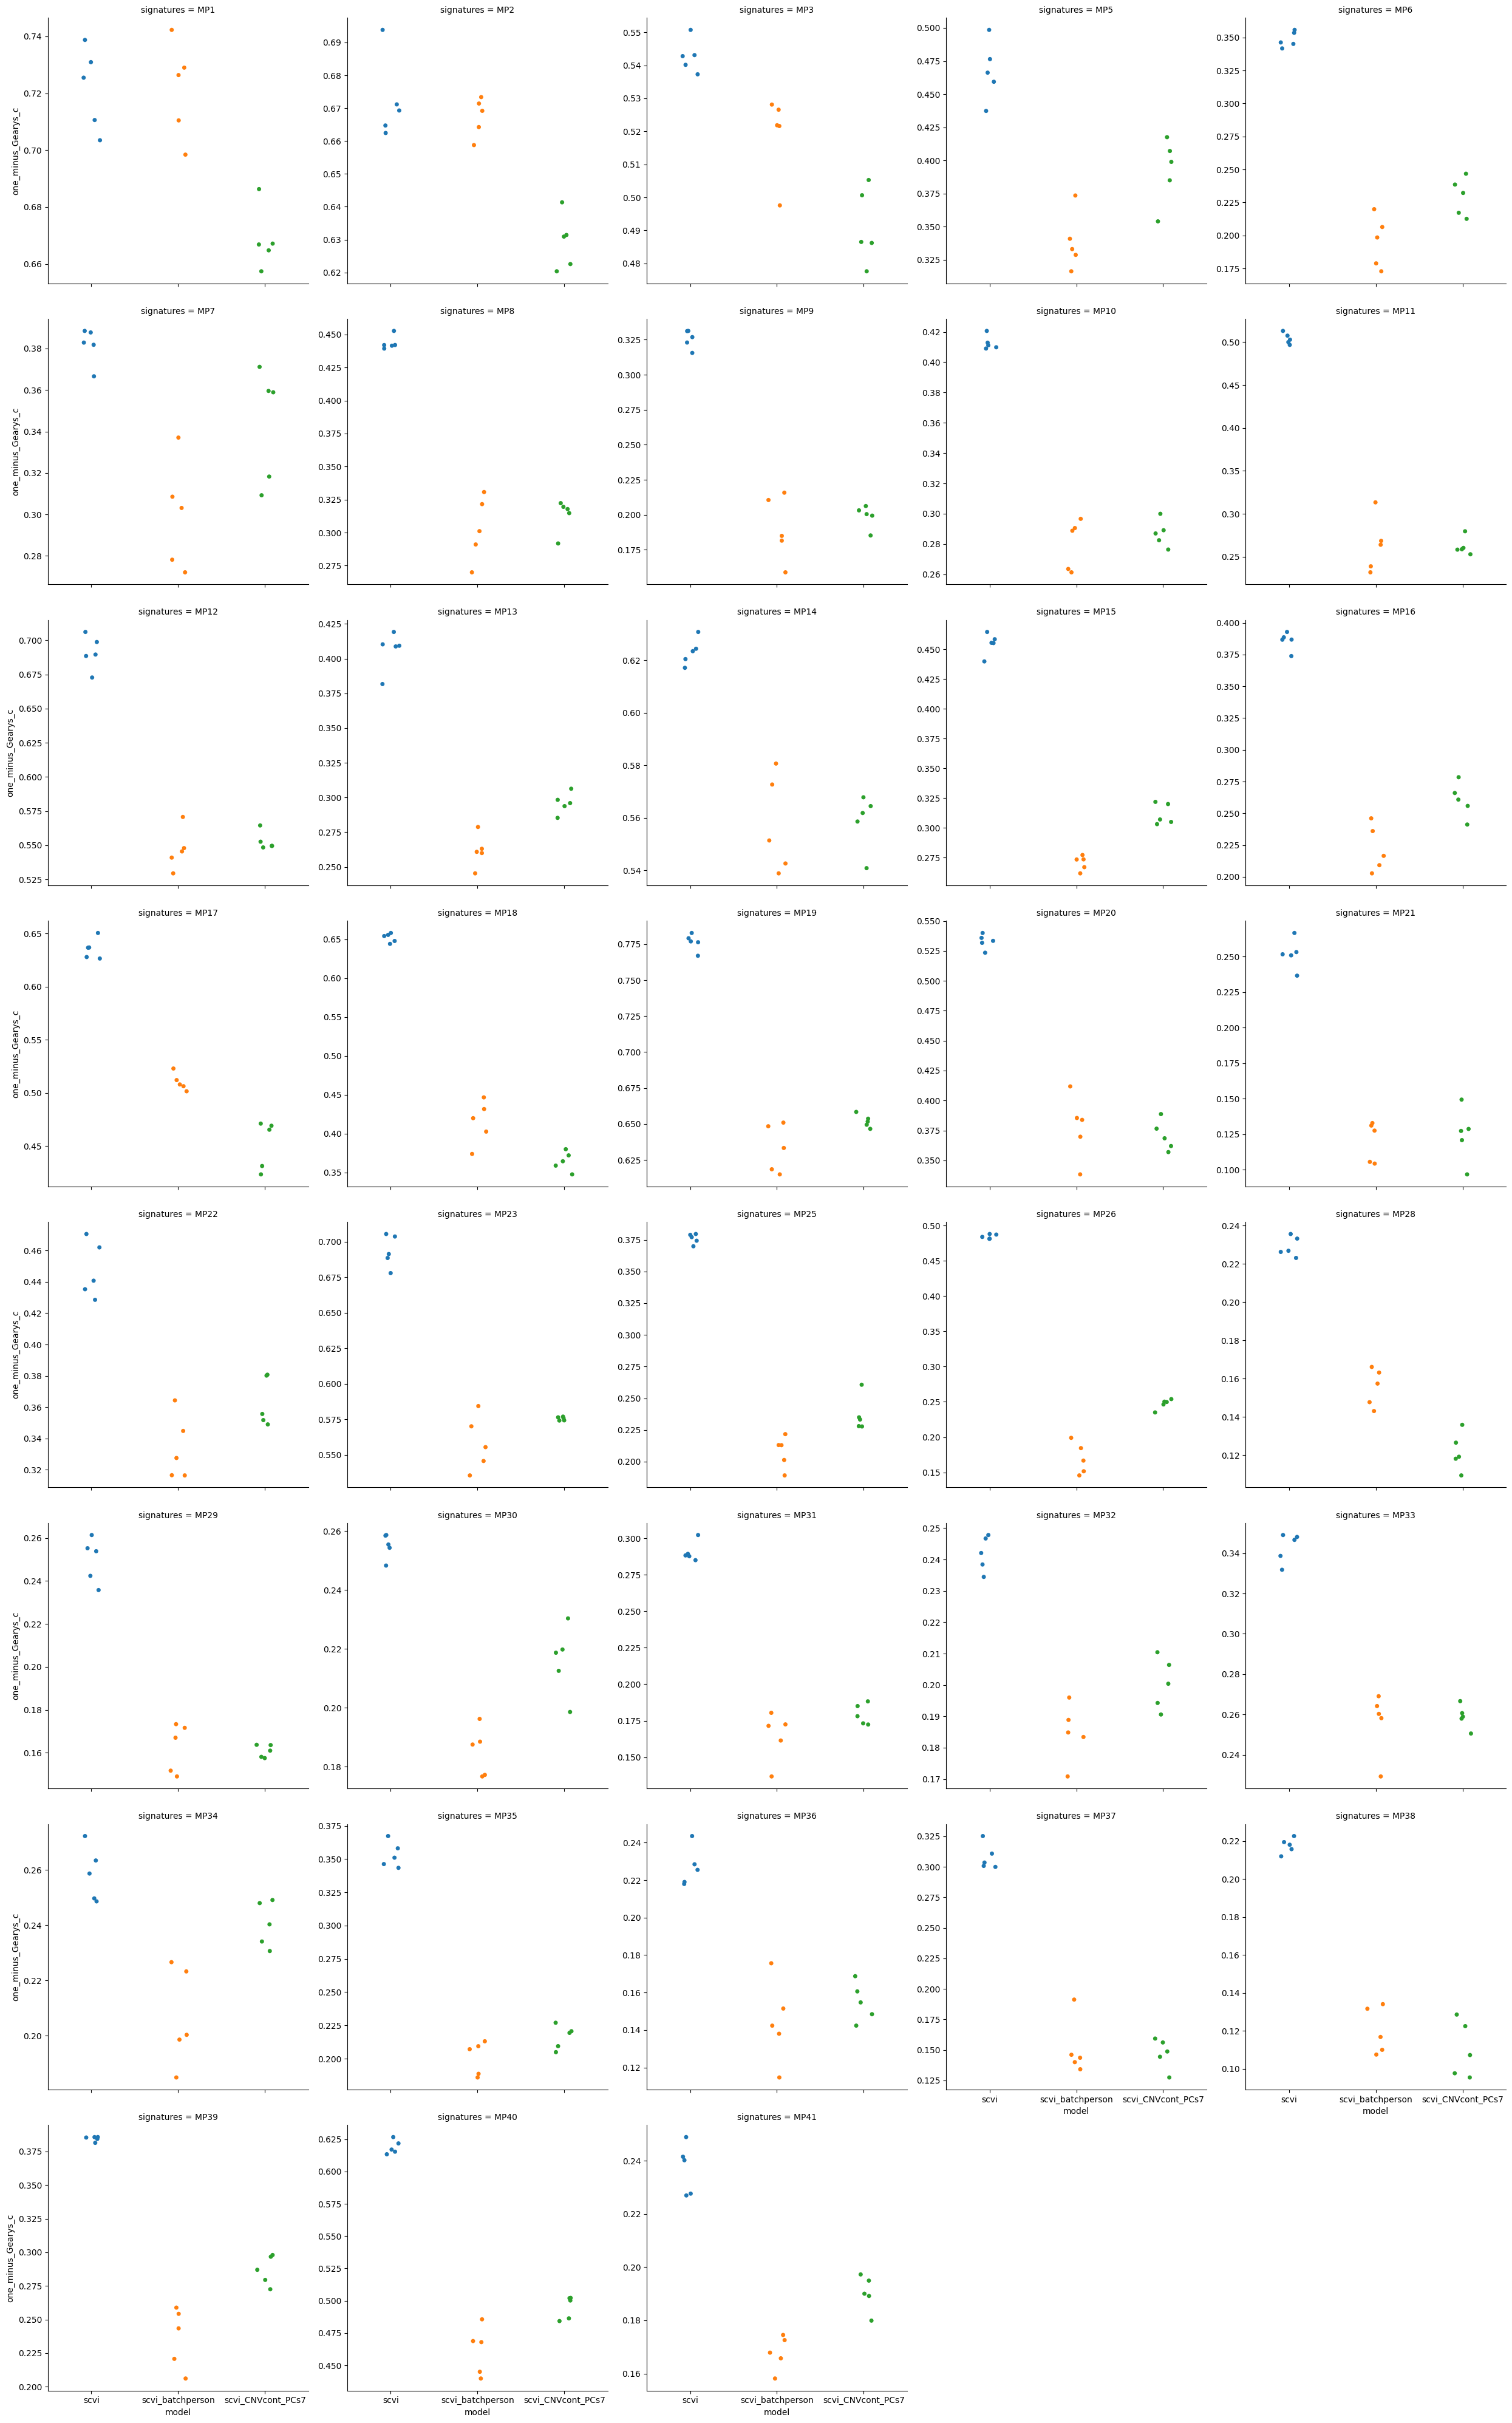

In [ ]:
all_cancerMP_gearys_df = pd.DataFrame(all_cancerMP_gearys)

all_cancerMP_gearys_df = all_cancerMP_gearys_df.melt(id_vars="signatures", var_name="run", value_name="one_minus_Gearys_c")

all_cancerMP_gearys_df['model'] = [("_").join(s.split("_")[:-1]) for s in all_cancerMP_gearys_df.run]
all_cancerMP_gearys_df['seed'] = [s.split("_")[-1] for s in all_cancerMP_gearys_df.run]

tmp = all_cancerMP_gearys_df[all_cancerMP_gearys_df.model=="scvi"].groupby('signatures').mean("one_minus_Gearys_c")
tmp = tmp[tmp.one_minus_Gearys_c > 0.2]
sns.catplot(data=all_cancerMP_gearys_df[all_cancerMP_gearys_df.signatures.isin(tmp.index)], x="model", y="one_minus_Gearys_c", hue="model", col="signatures", col_wrap=5, sharey=False)